## Basic Machine Learning using using scikit-learn with the Hillenbrand database

### PART I:  RECOGNIZE GENDER FROM PITCH

### 1. Setting up your Python Environment
The next two code blocks import required modules into the Python environment 
1. First a set of imports takes care of a default Python's Machine Learning Stack
    + i.e. a number of modules that are used across a very wide range of machine learning tasks
        - scipy, numpy & pandas are used for data manipulation and computations
        - matplotlib and seaborn are used for plotting
        - sklearn is Python's elementary machine learning toolkit
    + these imports are generous, we may not be using all of them; though at the same time, this is limited to the basics
    
2. We also import some local utilities that are needed for this exercise
    + These utilities are not part of any standard Python environment
    + Depending on where and how you run this file, you may have to modify the variable 'environment' 

In [1]:
# Importing Python's baseline machine learning stack  
% matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as sio
# import io as spchio

# imports from the scikit-learn 
from sklearn.datasets.base import Bunch
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

In [2]:
# IMPORT (and installation) of LOCAL PACKAGE 'spchutils'
#   
# set the variable 'ENVIRONMENT'  to: 
# - COLAB      when running this in the COLAB environment
# - INSTALLED  when you know that the package 'spchutils' is installed for you 
# - DEV        for developer mode
###################

ENVIRONMENT = "DEV"

if(ENVIRONMENT == "DEV"):
    package_dir = 'C:\\Users\\compi\\Nextcloud\\GitHub\\spchlab'        
    os.chdir(package_dir)
elif(ENVIRONMENT == "INSTALLED"):
    print("assuming spchutils is LOCAL installed")
elif(ENVIRONMENT == "COLAB"):
    ! pip install git+https://github.com/compi1234/spchlab.git
            
from spchutils.hildata import fetch_hillenbrand

### 2. The Database 
All experiments in this notebook are using (parts of) the Hillenbrand '95 database. For detailed information and references: http://homes.esat.kuleuven.be/~spchlab/datasets/hillenbrand/README.txt

The function *fetch_hillenbrand()* fetches the database with an interface similar to sklearn.
A subselection of the database can be made with criteria
+ data criteria
    - gender
    - vowel
    - features 
+ target criteria
    - gid  (gender identification)
    - vid  (vowel identification)

The output is by default provided in a Bunch object with contents:
- data: raw data for selected features
- target: classification labels (possibly multi-class)
- target_names
- feature_names

We first fetch the database with *fetch_hillenbrand()* and later on make further subselections of data and targets with *make_selection()* in function of a specific task.

In [92]:
# FETCH THE HILLENBRAND DATABASE
# By default fetch_hillenbrand() returns 
# - data for adult speakers only
# - features [f0,F1,F2,F3] 
# - [gid, vid] as targets
# to see more possibilities type  'help(fetch_hillenbrand)'
###############################################################
hillenbrand = fetch_hillenbrand(targets=['gid'],features=['f0'])
print('Features: ',hillenbrand.feature_names)
print('Targets: ',hillenbrand.target_names)
print('Data:\n ',hillenbrand.data)
#
###############################################################
# create a simple make_selection() module that allows subset selection on 
# an available database according to columns in the data and targets
# the target return is a list of integers according to 
def make_selection(dataset,feature_list=['f0'],target_list=['gid'],class_names=None):
    feat_indices =  [ dataset.feature_names.index(ft) for ft in feature_list ]
    target_indices =  [ dataset.target_names.index(t) for t in target_list ]
    X = dataset.data[:,feat_indices]
    y_names = dataset.target[:,target_indices].ravel()
    if class_names == None:
        class_names = np.unique(y)
    y = np.zeros(len(y_names),dtype=int)
    for k in range(0,len(class_names)):
        y[y_names == class_names[k]] = k

    return(X,y)
##################################################################

Features:  ['f0']
Targets:  ['gid']
Data:
  [[174.]
 [102.]
 [ 99.]
 ...
 [234.]
 [240.]
 [265.]]


In [4]:
# Make the correct subselection for the 
# TASK: RECOGNIZE GENDER from PITCH
#
# features(X): 
#   + *f0*:  continuous, 1-D feature (feature_name = 'f0')
# target(y):  
#    + *'m' or 'w'*:  binary classification  (target_name = 'gid')
#
features = ['f0']
target = ['gid']
class_names = ['m','w']
X,y = make_selection(hillenbrand,feature_list=features,target_list=target,class_names=class_names)
#classes = np.unique(y)

In [97]:
# FETCH THE RELEVANT PART OF THE HILLENBRAND DATABASE
# We specify 
#   - targets=['gid'] i.e. we want to do classification on gender
#   - features=['f0'] i.e. the only features exported from the database is 'f0' only
# to see more possibilities type  'help(fetch_hillenbrand)'
###############################################################
hillenbrand = fetch_hillenbrand(targets=['gid'],features=['f0'])
print('Features: ',hillenbrand.feature_names)
print('Targets: ',hillenbrand.target_names)
print('Data:\n ',hillenbrand.data)
X = hillenbrand.data
y = hillenbrand.target

Features:  ['f0']
Targets:  ['gid']
Data:
  [[174.]
 [102.]
 [ 99.]
 ...
 [234.]
 [240.]
 [265.]]


(1116, 1)

### 3. Data Exploration

All machine learning tasks start with a data exploration phase in which we try to understand a bit more of how the data is distributed over the different classes.
This may give us a hint as to which paradigm may be the best suited for tackling our problem.

#### Data Analysis of the unlabeled data -- Fitting with Gaussian Mixture Models
Gaussian Mixture Models are a popular method for fitting unknown densities. Sometimes the multiclass nature of the data will show up as a clear multimodal fit to the data.
In such cases the GMM fit can be used to discover the individual classes and GMMs can be used for clustering. If the number of gaussians does not match the number of classes or if the multimodal nature is not sufficiently pronounced then a blind clustering procedure with GMMs will yield a fuzzy result.
So the procedure only works well if classes are rather well separated and the number of classes is known in advance.

In our case (f0 data of a mixed male/female) we can expect 2 clusters with quite well separated distributions that are more or less Gaussian on top of that.
To further investigate the above we make fits to the data with 1,2,3 and 4 mixtures.

We make use of the *GaussianMixture()* module in the **sklearn** package.

##### Questions (1)
1. In which cases do we see underfitting or overfitting
2. In which cases do the individual means of the distributions give you common sense information about the distribution of either class
3. If you like to see what happens, with larger number of Gaussians, change the parameter max_gaussians = ... to a different number
4. Does the Gaussian mixture model fit the data well ?

ng=1:   [[177.24820789]]
ng=2:   [[130.30136855 220.82568753]]
ng=3:   [[150.68419319 222.0678659  119.23384176]]
ng=4:   [[148.0358162  236.27991305 116.95364025 210.293673  ]]


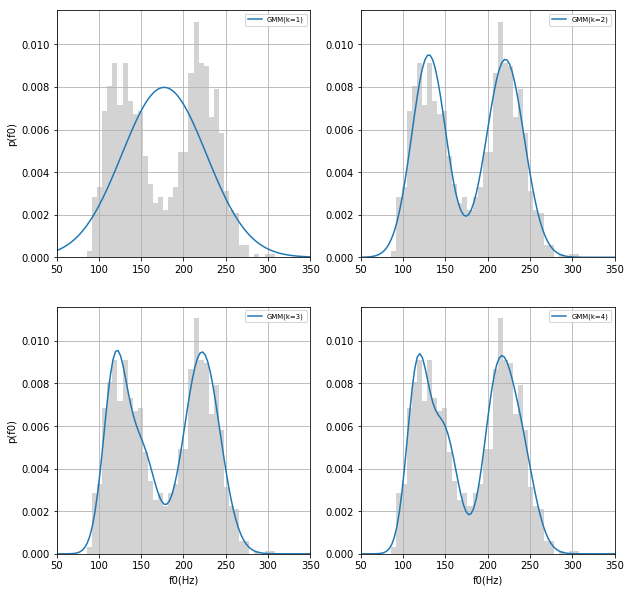

In [5]:
#from sklearn.mixture import GaussianMixture
max_gaussians = 4
nrows = int((max_gaussians+1)/2)

xmin =50.
xmax=350.
xp = np.linspace(xmin,xmax,100).reshape(-1,1)
# you need to do this reshaping as it expects 2D data with shape (n_samples,n_features)
 
fig, ax = plt.subplots(nrows,2, sharex=False, sharey=False, figsize=(10,10))
for i in range(0,max_gaussians) :
    ncomp = i+1
    gmm = GaussianMixture(max_iter=10,random_state=1,n_components=ncomp,init_params='kmeans')
    gmm.fit(X)
    print("ng=%d:  " % ncomp,gmm.means_.T)
    yp = gmm.score_samples(xp)  # returns the logprob of GMM likelihoods
    ii = int(i/2); jj=i%2
    ax[ii,jj].hist(X,bins=50,range=(xmin,xmax),density=True,color='lightgrey')
    ax[ii,jj].plot(xp,np.exp(yp),label='GMM(k=%d)' % ncomp)
    ax[ii,jj].set_xlim(xmin,xmax)
    if jj == 0:
        ax[ii,jj].set_ylabel('p(f0)')
    if ii == 1:
        ax[ii,jj].set_xlabel('f0(Hz)')
    ax[ii,jj].legend(loc='upper right',fontsize='x-small')
    ax[ii,jj].grid(True,which='major',axis='both')
plt.show()

##### Answers (1)
- (Q1&Q3) It is quite obvious that the 1-mixture fit yields a gross underfitting of the data.   The 3 and 4 mixture fits give additional information that is hard to interpret and it is probably nothing more than exhibition of overfitting. 
- (Q2) As expected the 2-mixture fit captures the  bimodal distribution very well.  Only in this case we may find rather expected mean values for pitch of male and female, respectively 130Hz and 220Hz.
- (Q4) The Gaussian mixture model does a pretty good job.  Obvious a gaussian distribution is not 'physically' correct as it gives a finite distribution to negative pitches or very high pitches while we know that no such pitches can not exist.

#### Data Analysis of the labeled data

If we may assume that all our data has been (correctly) labeled, then we get a better view of the data. For 1-D observations, as in this case, we still observe with histograms, for higher dimensional data we will use scatter plots. 
The plot below shows a simple 2 class histogram 

It may all look simple and trivial. However, some intuitive assumptions may rightfully be questioned.  We will explore two such things:  the number of bins in the histogram and the scaling of
the feature axis.

##### Questions (2):
1. The principle parameter that you can adjust in the code block below is the 'n_bins' parameter.  It sets the number of bins in the histograms.  There is no ABSOLUTE trutch value for n_bins. Try to explain how n_bins is related to the size of your database, the number of classes and/or the dimensionality of the feature vectors ?
2. Up till now we expressed pitch in the common physical unit 'Hz'.  However, from a musical perspective it is more common to express pitch on a musical/logarithmic scale.  In Western music an octave is divided into 12 equal parts on a logartihmic scale, also called *semitones*. Be aware that such musical scale, just as any other logarithmic scale, is a relative scale.  Do you see differences in how the data is distributed on a Hz or on a semitone scale ?  Is the Gaussian assumption work better for either scale ?  

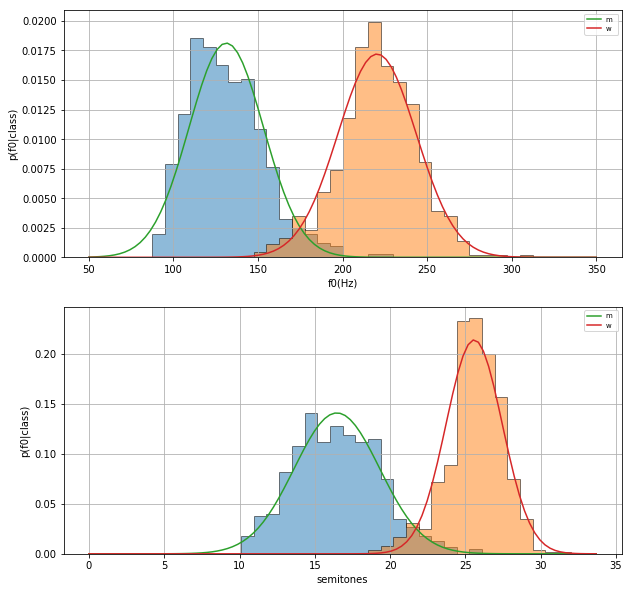

In [87]:
freq_scale = "Hz"                    # should be 'Hz' or 'semitones'
fit_gaussians = True                 # should be True or False
n_bins = 40                          # number of bins in the histograms
f0_range = np.asarray([50., 350.])   # frequency range in histograms
f0base = 50.                         # reference frequency (in Hz) for semitone scale

plt.close('all')
def freq2st(f,base=f0base):
    return 12*np.log2(f/base)

#
x1 = X[y==0]
x2 = X[y==1]
y1 = y[y==0]
y2 = y[y==1]
xlab = 'f0(Hz)'
ylab = 'p(f0|class)'

fig,ax = plt.subplots(2,1,figsize=(10,10))

for i in range(0,2):    
    if i == 1:
        x1= freq2st(x1)
        x2= freq2st(x2)
        f0_range = freq2st(f0_range)
        xlab = 'semitones'
    kwargs = dict(histtype='stepfilled', alpha=.5, bins=n_bins, density=True, ec="k")
    ax[i].hist(x1, **kwargs,range=f0_range)
    ax[i].hist(x2, **kwargs,range=f0_range)
    ax[i].set_xlabel(xlab)
    ax[i].set_ylabel(ylab)
    ax[i].grid(True)
    if(fit_gaussians):
        xp  = np.linspace(f0_range[0],f0_range[1],100).reshape(-1,1)
        for j in range(0,2):
            if(j==0):
                xdata = x1
            else:
                xdata = x2
            gmm = GaussianMixture(max_iter=3,random_state=1,n_components=1,init_params='kmeans')
            gmm.fit(xdata)
            yp = gmm.score_samples(xp)
            ax[i].plot(xp,np.exp(yp),label='%s ' % class_names[j])
        ax[i].legend(loc='upper right',fontsize='x-small')

plt.show()

In [7]:
my_test = np.array([ 150., 175., 200]).reshape(-1,1)

### 4. Classification using a Bayesian classifier and Gaussian models

We know now enough to create and test our classifier
1. split the data in 50% for training and 50% for test
    -  X_train, y_train, X_test, y_test
2. train the classifier based on the training data
    - given the data exploration before we choose to model the data in each class with a single Gaussian distribution 
3. construct a classifier using the Bayesian rule and posteriors
4. evaluate on test data

For this, we will use a the class *gmmclassifier* which is provided in *spchutils* as an extension to *sklearn*.  For people familiar with other sklearn classifiers like svm, perceptron, a.o. the interface will look very familiar.
The training is also nothing else than appropriate calls over multiple classes to GaussianMixture modules used above.  Inside the gmm

In [90]:
from spchutils.GaussianMixtureBC import GaussianMixtureBC
#**************#
n_components = 1
#**************#
X_train, X_test, y_train, y_test =  train_test_split(X,y,
          test_size=0.5, random_state=0)
clGM = GaussianMixtureBC(n_classes=2,n_components=n_components)
clGM.fit(X_train,y_train)
clGM.print()
#print("Classes: ",clGM.classes_)
y_pred = clGM.predict(X_test)
cmat = skmetrics.confusion_matrix(y_test,y_pred)
print('Confusion Matrix:\n',cmat)
print('Accuracy: %.3f' % skmetrics.accuracy_score(y_test, y_pred))

Class[0] with prior=0.471
[1.] [[128.82509506]] [[20.95622403]]
Class[1] with prior=0.529
[1.] [[220.30847458]] [[24.16194859]]
Confusion Matrix:
 [[259  18]
 [  6 275]]
Accuracy: 0.957


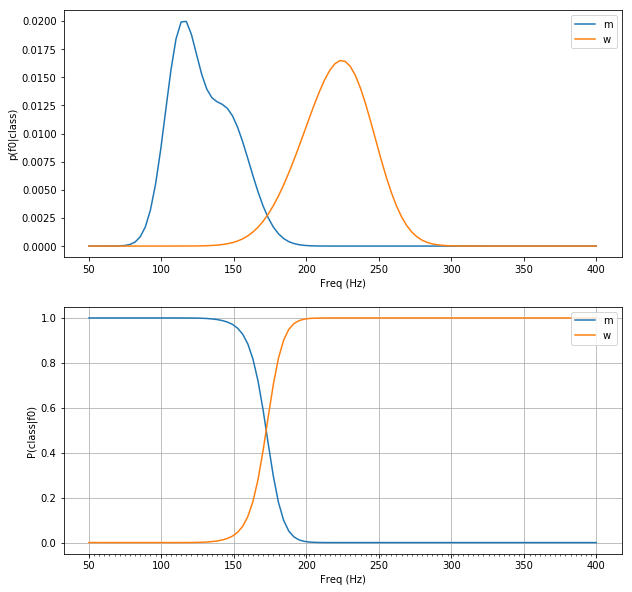

In [80]:
# have a look at the properties of the classifier
# by looking at likelihoods within class and 
# predicted probabilities per class over the whole pitch range
x = np.vstack(np.linspace(50.,400.,100))
fig,ax = plt.subplots(2,1,figsize=(10,10))

# 1. likelihoods
z = clGM.predict_prob(x)
h = ax[0].plot(x,z)
ax[0].set_xlabel("Freq (Hz)")
ax[0].set_ylabel("p(f0|class)")
ax[0].legend(class_names,loc='upper right')
# 2. posteriors
z = clGM.predict_proba(x)
h = ax[1].plot(x,z)
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("P(class|f0)")
ax[1].legend(class_names,loc='upper right')
ax[1].grid()
ax[1].set_xticks(x,minor=True)
plt.show()

In [54]:
# test on some independent data
my_test = np.arange(50.,400.,25.).reshape(-1,1)
print(clGM.class_prior_)
print(clGM.predict_proba(my_test))
#clGM

[0.47132616 0.52867384]
[[1.00000000e+00 3.89909513e-11]
 [1.00000000e+00 6.88821207e-11]
 [9.99999984e-01 1.57632945e-08]
 [9.99932204e-01 6.77961845e-05]
 [9.74280219e-01 2.57197806e-02]
 [3.00058231e-01 6.99941769e-01]
 [2.34036317e-02 9.76596368e-01]
 [1.20050279e-04 9.99879950e-01]
 [1.66138179e-07 9.99999834e-01]
 [7.34555481e-11 1.00000000e+00]
 [5.77977834e-15 1.00000000e+00]
 [2.07899636e-19 1.00000000e+00]
 [3.44449756e-24 1.00000000e+00]
 [2.62862014e-29 1.00000000e+00]]


In [55]:
tt2 = np.hstack((my_test, 2*my_test, 0.75*my_test))
tt2, tt2.shape
xmin = np.min(tt2,axis=0)
xmax = np.max(tt2,axis=0)
print(xmin,xmin.shape)
datarange=np.vstack((xmin,xmax))
print(datarange, datarange.shape)
vtest = np.vstack(my_test)
print(vtest)

[ 50.  100.   37.5] (3,)
[[ 50.   100.    37.5 ]
 [375.   750.   281.25]] (2, 3)
[[ 50.]
 [ 75.]
 [100.]
 [125.]
 [150.]
 [175.]
 [200.]
 [225.]
 [250.]
 [275.]
 [300.]
 [325.]
 [350.]
 [375.]]


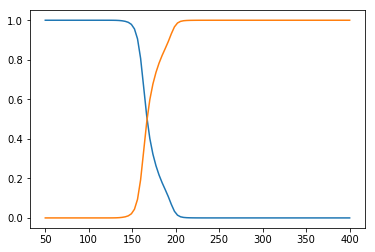

In [58]:
x = np.vstack(np.linspace(50,400,num=100))
z = clGM.predict_proba(x)
h = plt.plot(x,z)
plt.show()

In [57]:
from spchutils.gmmclassifier import gmmclassifier
#help(gclass)
# split the data in train and test samples 
X_train, X_test, y_train, y_test =  train_test_split(X,y,
          test_size=0.5, random_state=0)

# set the number of Gaussian components
ncomp = 1
nclass = len(class_names)
samples_per_class = np.zeros(nclass)
clgaus  = gmmclassifier(n_classes=nclass,n_g=1)
clgaus.fit(X_train,y_train)
clgaus.print()

#for k in range(0,2):
#        print(gmclass.gmm[k].weights_,gmclass.gmm[k].means_,
#              np.sqrt(gmclass.gmm[k].covariances_))

[1.] [[128.82509506]] [[20.95622403]]
[1.] [[220.30847458]] [[24.16194859]]


In [6]:
my_test = np.array([ 150., 175., 200]).reshape(-1,1)
nsamples = 3
n_classes = 2
class_likelihoods = clgaus.predict_prob(my_test)
total_likelihood = np.zeros(nsamples)
class_posteriors = np.zeros((nsamples,n_classes))
for k in range(0,n_classes):
    total_likelihood += class_likelihoods[:,k]
for k in range(0,n_classes):
    for i in range(0,nsamples):
        class_posteriors[i,k] = class_likelihoods[i,k] / total_likelihood[i]
print(class_posteriors)

[[0.9794789  0.0205211 ]
 [0.37122813 0.62877187]
 [0.00510682 0.99489318]]


In [31]:
my_test[1] = 172.1
clGM.class_prior_ = [.5, .5]
print(clGM.predict_proba(my_test))


[[0.9794789  0.0205211 ]
 [0.50016459 0.49983541]
 [0.00510682 0.99489318]]


In [11]:
pred, post = clgaus.predict(my_test,posteriors=True)
print(pred, post)
print( pd.DataFrame(np.concatenate((my_test,pred.reshape(-1,1),post),axis=1),columns=['X','pred','p1','p2']) )

[0 1 1] [[0.9794789  0.0205211 ]
 [0.37122813 0.62877187]
 [0.00510682 0.99489318]]
       X  pred        p1        p2
0  150.0   0.0  0.979479  0.020521
1  175.0   1.0  0.371228  0.628772
2  200.0   1.0  0.005107  0.994893


In [47]:
from sklearn.metrics import accuracy_score

y_pred = clgaus.predict(X_test)
#print(y_pred,y_test)
#y_pred = ppn.predict(X_test_std)
errorindx = (y_test != y_pred)
errorindx,errorindx.sum()
#print('Misclassified samples:  ', errorindx)
print(y_pred)
print(y_test)
#print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

[1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 1
 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1
 0 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0
 1 1 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0
 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1
 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 0
 1 0 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 1 1 1
 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1
 0 0 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 0
 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1
 0 1 1 0 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1
 1 0 1 1 0 0 0 1 1 0 0 0 

In [34]:
# split the data in train and test samples 
X_train, X_test, y_train, y_test =  train_test_split(X,y,
          test_size=0.5, random_state=0)

# set the number of Gaussian components
ncomp = 1
nclass = len(classes)
samples_per_class = np.zeros(nclass)
# model the distributions in each class
gmm = [GaussianMixture(max_iter=10,random_state=1,n_components=ncomp, 
                        init_params='kmeans') for k in range(0,nclass)]
for k in range(0,nclass) :
    ksel = [y_train[i] == classes[k] for i in range(len(y_train))]
    samples_per_class[k] = len(y_train[ksel])
    XX = X_train[ksel,:]
    gmm[k].fit(X_train[ksel],y_train[ksel])
    
print("Mean and Variances per class")
for k in range(0,nclass) :
    print("Class: %s,  n_samples: %d" % (classes[k],samples_per_class[k]))
    print(gmm[k].means_,np.sqrt(gmm[k].covariances_))
    print("\n")

Mean and Variances per class
Class: m,  n_samples: 263
[[128.82509506]] [[[20.95622403]]]


Class: w,  n_samples: 295
[[220.30847458]] [[[24.16194859]]]




In [ ]:
# compute likelihood and posteriors for test dataset
nsamples = len(X_test)
x_lik = np.zeros(nsamples)
x_class_lik = np.zeros((nsamples,nclass))
x_class_post = np.zeros((nsamples,nclass))
for k in range(0,nclass):
    x_class_lik[:,k] =np.exp( gmm[k].score_samples(X_test) )
    x_lik = x_lik + x_class_lik[:,k]
for k in range(0,nclass):
    x_class_post[:,k] = x_class_lik[:,k] / x_lik
    
y_true = np.array(['m']*nsamples)

war = x_class_post[:,1] > x_class_post[:,0]
print(war)

for i in range(0,nsamples):
    if (war[i]):
        y_true[i] = 'w' 

for y,yt in zip(y_test,y_true):
    print(y,yt)
    
for x,y,yt in zip(x_class_post,y_test,y_true):
    if y != yt:
        print(x,y,yt)

In [24]:
aa = np.zeros((3,),dtype=int)
print(aa)

[0 0 0]


In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
print(sc.mean_, sc.var_)
X_train_std = X_train -177
X_test_std = X_test - 177

In [ ]:
from sklearn.linear_model import Perceptron

ppn = Perceptron(max_iter=40, tol=0.01, random_state=0)
ppn.fit(X_train_std, y_train)
print(ppn.classes_,ppn.n_iter_)
print(ppn.coef_,ppn.intercept_)


In [91]:
help(fetch_hillenbrand)

Help on function fetch_hillenbrand in module spchutils.hildata:

fetch_hillenbrand(genders='adults', vowels=[], features=['f0', 'F1', 'F2', 'F3'], targets=[], Debug=False, return_X_y=False)
    The function load_hillenbrand() loads the Hillenbrand dataset in a similar way as the datasets in sklearn.
    There are extra arguments that lets one select parts of the database for further use.
    The subset selection is specified by the arguments  (genders, vowels, features, targets)
    
    The Hillenbrand dataset is a 1995 repeat and extension of the classic Peterson-Barney(1953) experiment
    in which Formants are established as compact and highly discriminative features for vowel recognition
    (c) 1995 James Hillenbrand
    https://homepages.wmich.edu/~hillenbr/voweldata.html
    
    The interface provided here reads from a copy of the data at ESAT stored in a more 
    convenient csv format and in which the 0 values (not available) are replaced by #N/A
    
    =================  